## Imports and dataset

In [1]:
from src.models.optimized_bnn import ClasBayesianNNVI
from src.attacks.distr_attacks_bnn_jax import mlmc_attack, fgsm_attack, kl_to_appd

from src.utils import plot_ppds

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
import numpyro
numpyro.set_host_device_count(8)

In [4]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

## MNIST - DE

In [5]:
# load MNIST data without tensorflow
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.values, mnist.target.values
X = X / 255.0  # Normalize pixel values to [0, 1]
y = y.astype(int)
y = jax.nn.one_hot(y, 10)

# Split into training and testing datasets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [6]:
modelVI = ClasBayesianNNVI(input_dim=X_train.shape[1], hidden_units=3)
try:
    modelVI.load('../src/models/weights/mnist/3bnnvi')
except FileNotFoundError:
    print('Not model found, fitting the model') 
    modelVI.fit(
        X_train, 
        jnp.argmax(y_train, axis=1), 
        num_steps=5000
    )
    modelVI.save('../src/models/weights/mnist/3bnnvi')

In [7]:
# Load notMNIST data without labels
import os
from PIL import Image
import numpy as np

# Ruta de la carpeta con imágenes
folder_path = '../data/notMNIST_small'

# Lista para almacenar las imágenes
images = []

for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        if filename.endswith('.png'):
            img_path = os.path.join(dirpath, filename)
            img = Image.open(img_path)
            img_gray = img.convert('L')
            img_array = np.array(img_gray)
            images.append(img_array)

X_notmnist = np.array(images).reshape(-1, 28*28) / 255.0

## Trying to break them

In [8]:
x = X_test[0]
x = jnp.array(x).reshape(1, -1)
modelVI.sample_predictive_distribution(x, 20).shape

(20, 1, 10)

In [9]:
def entropy(x, pred):
    pred += 1e-8
    entr = - (pred * jnp.log(pred)).sum(axis=-1) / jnp.log(2)
    return entr.mean()

  0%|          | 0/8 [00:00<?, ?it/s]/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Early stopping at iteration 12


100%|██████████| 8/8 [01:13<00:00,  9.25s/it]


Early stopping at iteration 101
Early stopping at iteration 59
Early stopping at iteration 18
Early stopping at iteration 479


100%|██████████| 8/8 [00:01<00:00,  5.12it/s]


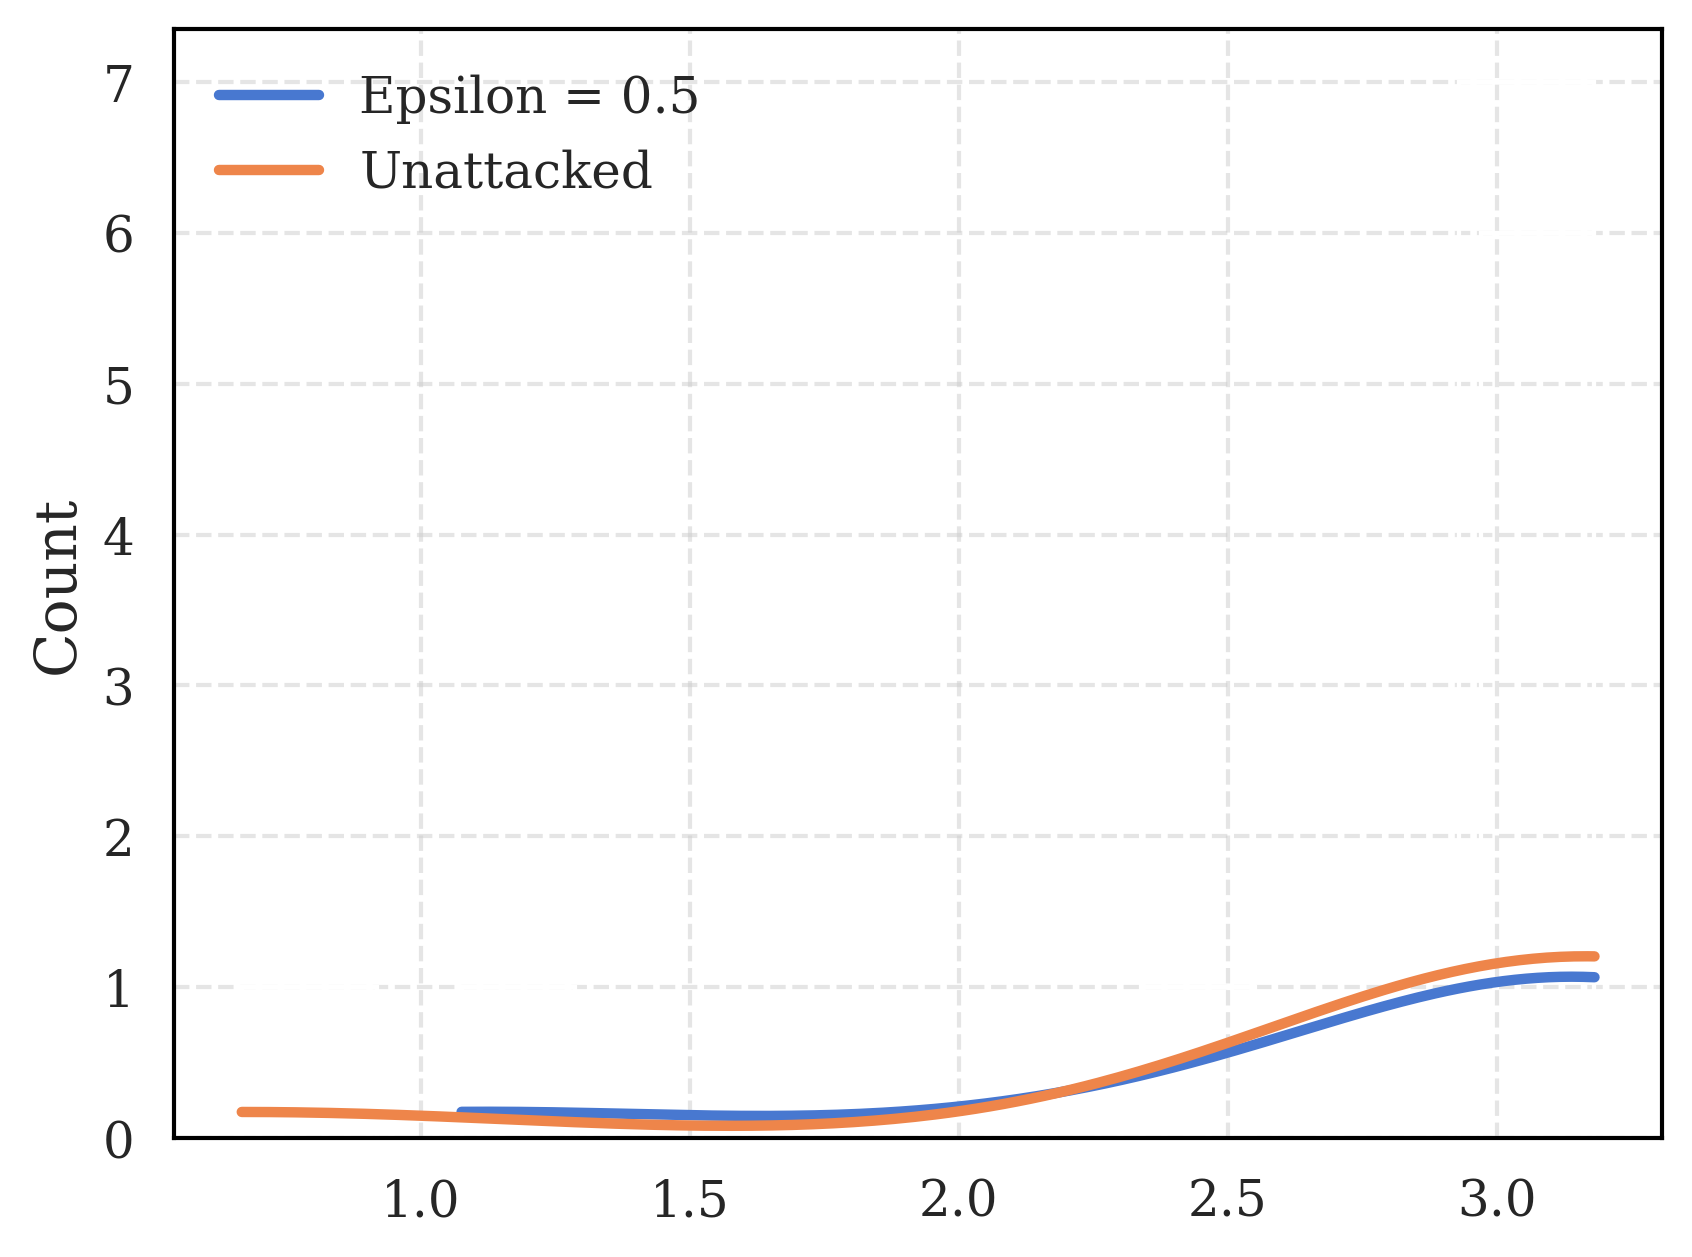

In [10]:
# Y is a uniform distribution over 10 classes
obj_appd = numpyro.distributions.Categorical(jnp.ones(10) / 10)

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps)
    preds = modelVI.sample_predictive_distribution(x_adv, 20)
    return entropy(x_adv, preds)

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
epsilons = [.5]
for eps in epsilons:
    entropies = Parallel(n_jobs=4)(delayed(process)(x, eps) for x in tqdm(X_test[:8]))  # TODO 80 points
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)
    
unattacked_entropies = []
for x in tqdm(X_test[:8]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution(x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


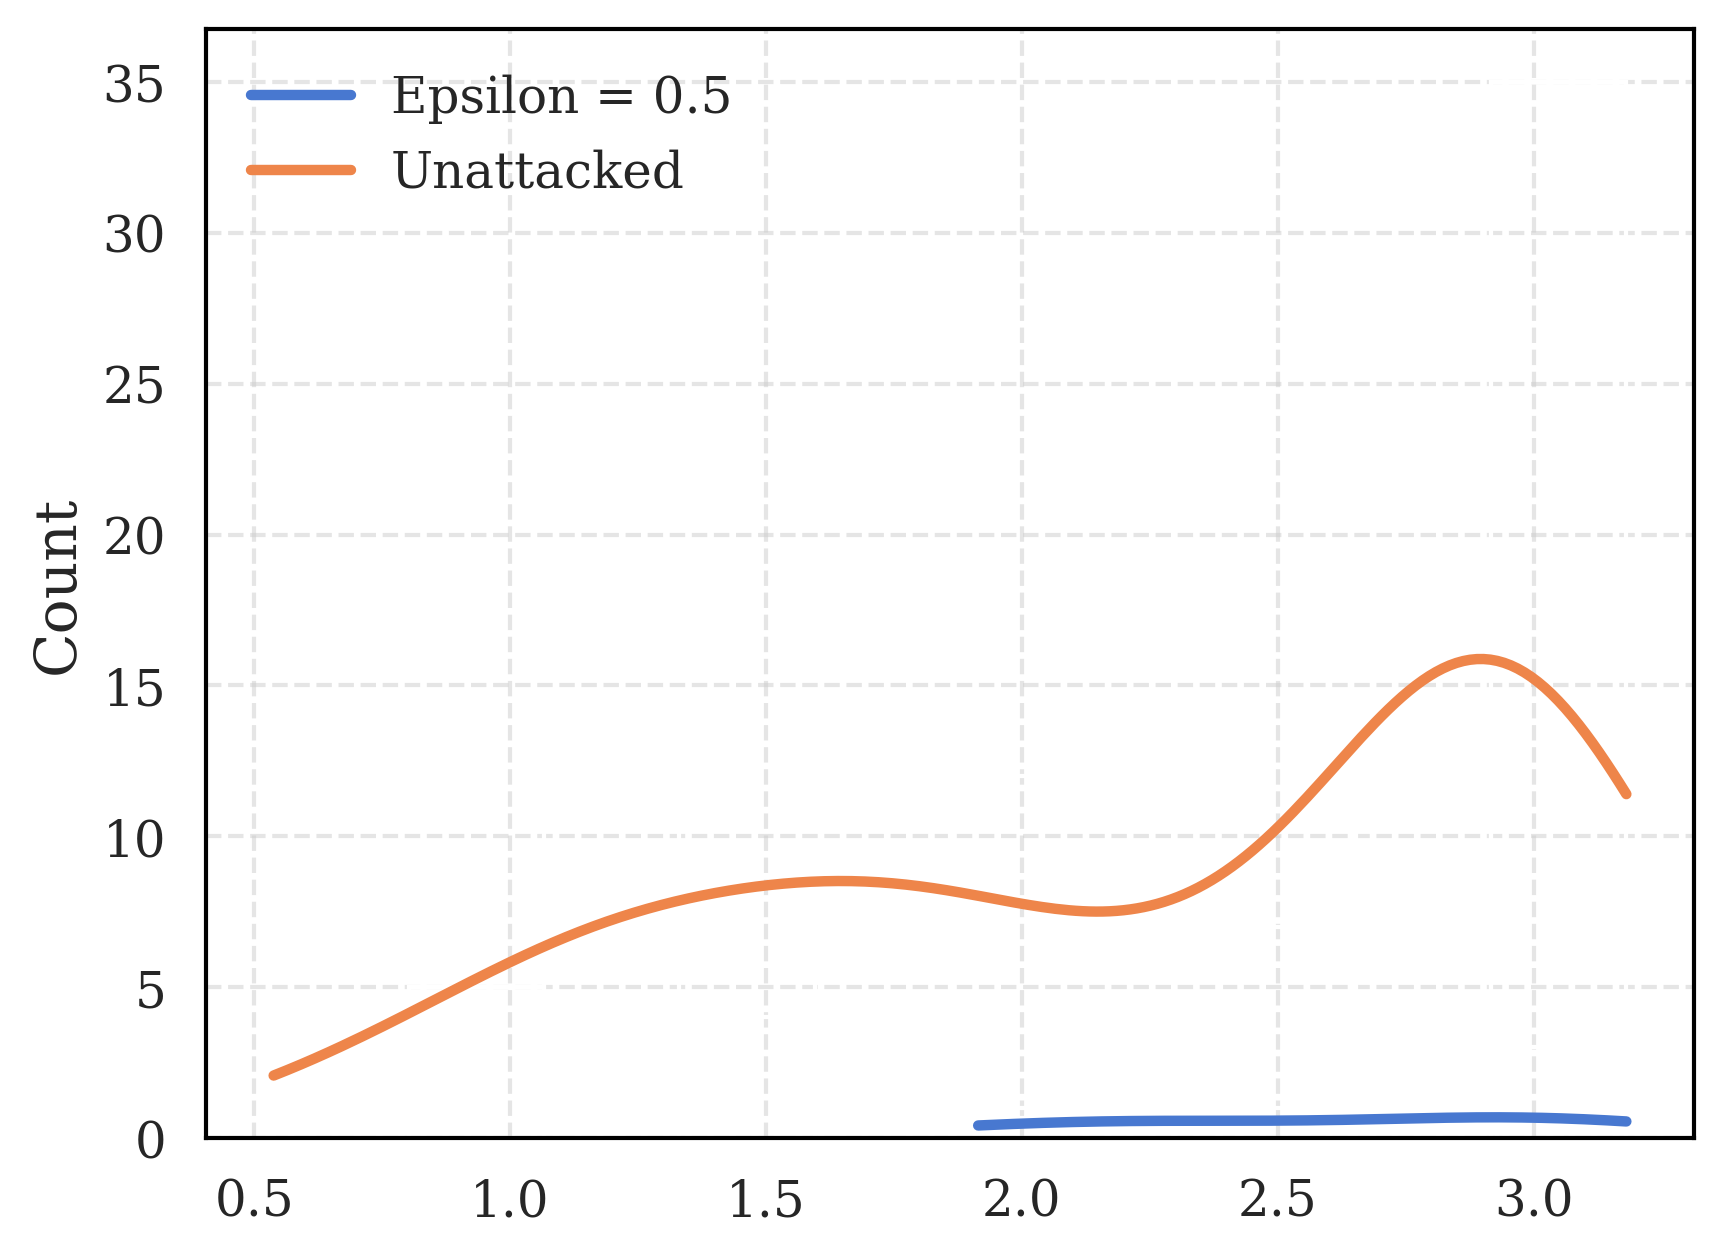

In [13]:
G = 0  # we want to lower the entropy of the predictive distribution

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
epsilons = [0.5]
for eps in epsilons:
    entropies = Parallel(n_jobs=4)(delayed(process)(x, eps) for x in tqdm(X_notmnist[:8]))  # TODO 80 points
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)

unattacked_entropies = []
for x in tqdm(X_notmnist[:100]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution(x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)